In [1]:
import sys
sys.path.insert(0, "../../")

from src.instruction_utility import *
from src.utility import *

import pandas as pd

import matplotlib.pyplot as plt

Lets get all metadata files in "models/":

In [2]:
candidate_files = []
for root, directory, files in os.walk(os.path.join(get_project_dir(), "models")):
    for file in files:
        if file.endswith(".meta"):
            candidate_files.append(file)

Now filter all the files that have written logs, which are not None and also provide TopKValidation predictions:

In [3]:
valid_metadata = []

for file in candidate_files:
    metadata = load_metadata(file)
    if "logs" in metadata.keys():
        if metadata["logs"] != "None":
            if "TopKValidation" in metadata["logs"].keys():
                valid_metadata.append(metadata)

# Best Top K  Scores

In [4]:
def best_top_k_from_meta(metadata):
    topk = metadata["logs"]["TopKValidation"]
    best_top_k = {
        "top_k_sum": 0.0,
        "top_k_sum_epoch": 0.0,
    }

    for epoch in topk.keys():
        top_k_sum = 0.
        for k in topk[epoch].keys():
            if k in best_top_k.keys():
                if best_top_k[k] < topk[epoch][k]:
                    best_top_k[k] = topk[epoch][k]
                    best_top_k[k+"_epoch"] = epoch
            else:
                best_top_k[k] = topk[epoch][k]
                best_top_k[k+"_epoch"] = epoch
            top_k_sum += topk[epoch][k]

        if best_top_k["top_k_sum"] < top_k_sum:
            best_top_k["top_k_sum"] = top_k_sum
            best_top_k["top_k_sum_epoch"] = epoch
    return best_top_k
    
best_top_k_from_meta(valid_metadata[0])

{'top_k_sum': 0.9950000000000001,
 'top_k_sum_epoch': '20',
 'top_1': 0.2169,
 'top_1_epoch': '38',
 'top_5': 0.3555,
 'top_5_epoch': '20',
 'top_10': 0.4267,
 'top_10_epoch': '20'}

In [5]:
tmp_list = []
for metadata in valid_metadata:
    tmp_dict = best_top_k_from_meta(metadata)
    tmp_dict["saved_model"] = metadata["saved_model"]
    tmp_list.append(tmp_dict)
df = pd.DataFrame(tmp_list)

In [6]:
df.sort_values(by="top_1", ascending=False)

,top_k_sum,top_k_sum_epoch,top_1,top_1_epoch,top_5,top_5_epoch,top_10,top_10_epoch,saved_model
5,1.003500,32,0.218600,36,0.359900,32,0.427900,32,models/simple_conv2d_angular_distance.h5
0,0.995000,20,0.216900,38,0.355500,20,0.426700,20,models/simple_conv2d_embedding_size_16.h5
7,0.992800,27,0.216900,27,0.357300,27,0.428500,40,models/simple_conv2d_embedding_size_64-0.h5
1,0.975872,23,0.216860,23,0.342733,23,0.418023,28,models/simple_conv2d_margin_0.75.h5
4,0.985500,24,0.211600,24,0.354400,24,0.419500,24,models/simple_conv2d_embedding_size_32.h5
8,0.974419,26,0.209302,26,0.348547,26,0.416570,26,models/simple_conv2d_margin_1.25.h5
10,0.817442,48,0.171221,47,0.292151,48,0.356395,47,models/simple_conv2d_margin_0.75_angular.h5
14,0.690698,95,0.163953,93,0.243023,70,0.286047,95,models/simple_conv2d_hard_loss.h5
3,0.728488,1,0.125581,47,0.274709,1,0.352035,1,models/simple_conv2d_margin_1.25_angular.h5
2,0.524128,89,0.101163,80,0.186919,68,0.239244,74,models/simple_conv2d_batch.h5


In [7]:
valid_metadata[1]

{'saved_model': 'models/simple_conv2d_margin_0.75.h5',
 'tensorboard_log_dir': 'reports/tensorboard_logs/simple_conv2d_margin_0.75',
 'best_top_1_model': 'models/simple_conv2d_margin_0.75_best_top_1.h5',
 'git_commit': 'ca405c3',
 'instruction': {'train_data': {'dataframe': 'data/processed/category_id_1_min_pair_count_10_deepfashion_train.joblib',
   'factory': 'src.data.triplet_dataset_factory.TripletDatasetFactory',
   'kwargs': {'batch_size': 64, 'data_slice_ratio': 1.0, 'shuffle': 'True'}},
  'validation_data': 'None',
  'model': {'factory': 'src.models.simple_conv2d_triplet_model_factory.SimpleConv2DTripletModelFactory',
   'kwargs': {'input_shape': [224, 224, 3],
    'embedding_size': 32,
    'filters_per_conv_layer': [16, 32, 64, 128, 256],
    'size_dense_layers': [512, 256]},
   'load': 'None',
   'fit': {'kwargs': {'epochs': 50}}},
  'loss': {'loss': 'tensorflow_addons.losses.TripletSemiHardLoss',
   'kwargs': {'margin': 0.75, 'distance_metric': 'L2'}},
  'optimizer': {'optim

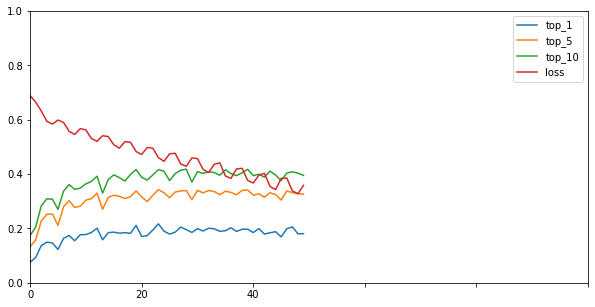

In [8]:
def plot_full_logs(metadata):
    tmp_df = pd.DataFrame(metadata["logs"]["TopKValidation"])
    tmp_df=tmp_df.transpose()
    tmp_df["loss"] = metadata["logs"]["history"]["loss"]
    tmp_df.plot(xlim=(0,100),ylim=(0,1), figsize=(10,5))

plot_full_logs(valid_metadata[1])